In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-whitegrid')
%matplotlib inline
import pickle
from collections import defaultdict
import pprint

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

pd.set_option('max_rows', 10)
pd.set_option('max_columns', 30)
pd.set_option('max_colwidth', -1)
# pd.set_option('display.width', 150)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# # Change format of charts to .svg
%config InlineBackend.figure_format = 'svg'

In [4]:
%xmode Plain

Exception reporting mode: Plain


In [5]:
df = pd.read_csv('data/clean_data_encoded_for_regression.csv')

X = df[['gender', 'senior', 'partner', 'dependents', 'tenure', 'phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges',
       'avg_monthly_charges', 'internet_service-fiber_optic',
       'internet_service-no', 'contract-one_year', 'contract-two_year',
       'payment_method-credit_card_auto', 'payment_method-electronic_check',
       'payment_method-mailed_check']]

y = df['churn']

# Stratify our train-test-split so that we have a balanced split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y)

#### Upsample with SMOTE to get a balanced dataset

Currently, only 27% of our dataset is categorized as "Churn" (i.e., will leave the telecom company and no longer be a customer this month). In order to train our model better, we are upsampling with SMOTE so that 50% of our dataset is categorized as "Churn". This makes sense because we are more concerned about recall (making sure our model catches nearly everyone who is likely to churn) than it is about precision.

The rationale? It's much cheaper to keep an existing customer than to acquire a new one.

In [6]:
sm = SMOTE(random_state=42, ratio=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print(y_train.value_counts(), np.bincount(y_train_res))

0    3614
1    1308
Name: churn, dtype: int64 [3614 3614]


### Let's do some quick and dirty analyses to determine which models we should tune further

First we'll do ANOTHER train test split on the training set. We want to make sure that we leave our actual test data (X_test and y_test) alone.

In [7]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_train_res, y_train_res, test_size=0.33, random_state=20)

In [8]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtrain,ytrain),model.score(xtest, ytest)


def quick_test_a_few_times(model, X, y, n=10):
    return (pd.DataFrame([quick_test(model, X, y) for j in range(n)],
                         columns=['Train Acc','Test Acc'])).mean()

new_model = make_pipeline(StandardScaler(), LinearSVC(max_iter=10000))
# pred = new_model.predict(X_test)
# Do the test 10 times with a LinearSVC and get the average score
print(quick_test_a_few_times(new_model, X_train_2, y_train_2))

Train Acc    0.771909
Test Acc     0.764418
dtype: float64


In [9]:
def get_scores(model):
    mod = model
    mod = mod.fit(X_train_2, y_train_2)
    predictions = mod.predict(X_test_2)
    # quick_test_a_few_times(decisiontree, X_train, y_train)

    print(f'Train accuracy: {mod.score(X_train_2, y_train_2)}')
    print(f'Test accuracy: {mod.score(X_test_2, y_test_2)}')
    print(f'Precision: {precision_score(y_test_2, predictions)}')
    print(f'Recall: {recall_score(y_test_2, predictions)}')
    print('\n')
    print(classification_report(y_test_2, predictions))

#### Decision Tree

In [25]:
decisiontree = DecisionTreeClassifier()
quick_test_a_few_times(decisiontree, X_train_2, y_train_2)

Train Acc    0.999646
Test Acc     0.799725
dtype: float64

#### Random Forests

In [26]:
randomforest = RandomForestClassifier()
quick_test_a_few_times(randomforest, X_train_2, y_train_2)

Train Acc    0.990292
Test Acc     0.847626
dtype: float64

#### Gradient Boosting Classifier

In [27]:
gradboost = GradientBoostingClassifier()
quick_test_a_few_times(gradboost, X_train_2, y_train_2)

Train Acc    0.887164
Test Acc     0.855678
dtype: float64

#### AdaBoost Classifier

In [28]:
adaboost = AdaBoostClassifier()
quick_test_a_few_times(adaboost, X_train_2, y_train_2)

Train Acc    0.855916
Test Acc     0.844873
dtype: float64

#### Logistic Regression

In [29]:
logreg = LogisticRegression()
quick_test_a_few_times(logreg, X_train_2, y_train_2)

Train Acc    0.773739
Test Acc     0.764763
dtype: float64

#### Linear SVC (Support Vector Classifier)

In [30]:
linearsvc = LinearSVC()
quick_test_a_few_times(linearsvc, X_train_2, y_train_2)

Train Acc    0.625671
Test Acc     0.624983
dtype: float64

#### SVC with rbf kernel

In [31]:
svc_rbf = SVC(kernel='rbf')
quick_test_a_few_times(svc_rbf, X_train_2, y_train_2)

Train Acc    0.963588
Test Acc     0.759601
dtype: float64

#### SVC with Polynomial kernel

In [ ]:
svc_poly = SVC(kernel='poly')
quick_test_a_few_times(svc_poly, X_train_2, y_train_2)

#### Naive Bayes Classifier

In [ ]:
gaussian_naive_bayes = GaussianNB()
quick_test_a_few_times(gaussian_naive_bayes, X_train_2, y_train_2)

### Adding in pipeline

In [ ]:
model = make_pipeline(StandardScaler(), SVC())
model.fit(X_train_2, y_train_2)
pred = model.predict(X_test_2)

quick_test_a_few_times(model, X_train_2, y_train_2)

In [ ]:
model = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
model.fit(X_train_2, y_train_2)
pred = model.predict(X_test_2)

quick_test_a_few_times(model, X_train_2, y_train_2)

In [ ]:
decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train_2, y_train_2)
coeffs = decisiontree.feature_importances_ # it's a percentage

list_of_coeffs = list(sorted(zip(coeffs, X.columns)))

In [ ]:
import pprint
pprint.pprint(list_of_coeffs)

In [ ]:
list_of_coeffs = list(sorted(zip(coeffs, X.columns)))
pprint.pprint(list_of_coeffs)

In [ ]:
gradboost = GradientBoostingClassifier()
gradboost.fit(X_train_2, y_train_2)
gradboost.feature_importances_ # values are between 0 and 1, not normalized
gradboost.train_score_.mean()

In [ ]:
s2 = LinearSVC()
s2.fit(X_train, y_train)
s2.coef_ # the absolute value dictates importance

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.coef_ # the abosulute value dictates importance

### ROC Curve

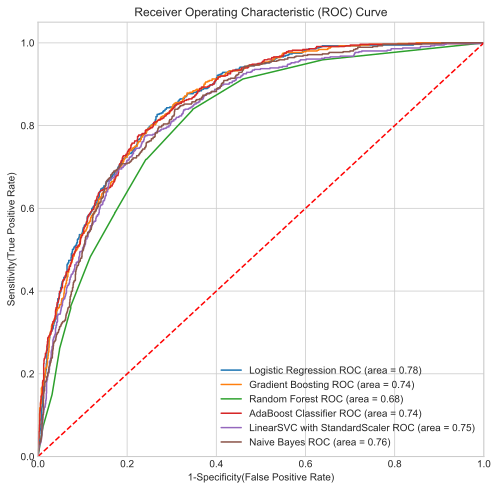

In [11]:
plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': make_pipeline(StandardScaler(), LogisticRegression())
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'AdaBoost Classifier',
    'model': AdaBoostClassifier(),
},
{
    'label': 'LinearSVC with StandardScaler',
    'model': make_pipeline(StandardScaler(), SVC(probability=True)),
},
{
    'label': 'Naive Bayes',
    'model': GaussianNB()
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_res, y_train_res) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('visualizations/ROC_curve.svg')

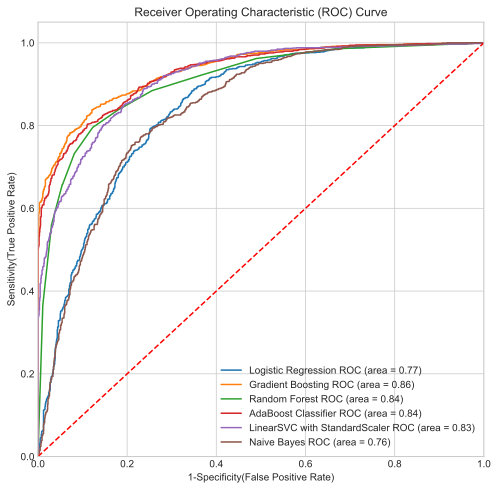

In [13]:
plt.figure(figsize=(8,8))

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(),
},
{
    'label': 'AdaBoost Classifier',
    'model': AdaBoostClassifier(),
},
{
    'label': 'LinearSVC with StandardScaler',
    'model': make_pipeline(StandardScaler(), SVC(probability=True)),
},
{
    'label': 'Naive Bayes',
    'model': GaussianNB()
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train_2, y_train_2) # train the model
    y_pred=model.predict(X_test_2) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test_2, model.predict_proba(X_test_2)[:,1])
# Calculate Area under the curve to display on the plot
    auc = roc_auc_score(y_test_2,model.predict(X_test_2))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('visualizations/ROC_curve.svg')

In [44]:
param_grid = {'C': [0.1, 10.]}

clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(LogisticRegression(),
                                 param_grid=param_grid,
                                 cv=2,
                                 refit=True))

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [45]:
y_test

5405    1
1247    1
5414    1
6666    0
4073    0
       ..
842     1
6797    0
6831    0
7012    0
3974    0
Name: churn, Length: 2321, dtype: int64

In [46]:
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [47]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1701
           1       0.62      0.55      0.58       620

   micro avg       0.79      0.79      0.79      2321
   macro avg       0.73      0.71      0.72      2321
weighted avg       0.78      0.79      0.79      2321



In [48]:
df['churn'].value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [49]:
1869/(5163+1869)

0.26578498293515357

In [50]:
clf = make_pipeline(StandardScaler(), 
                    GridSearchCV(LogisticRegression(),
                                 param_grid={'C': [0.1, 1.0, 10.]},
                                 cv=3,
                                 refit=True))

In [51]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_c...}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0))])

In [52]:
new_x = pd.DataFrame(X_train)

In [53]:
new_x.shape

(4711, 24)

In [54]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('gridsearchcv', GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_c...}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0))])

In [55]:
new = clf.predict(new_x)

In [56]:
print(classification_report(y_test, new))

ValueError: Found input variables with inconsistent numbers of samples: [2321, 4711]

### Logistic Regression Tuning

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression())])
param_grid = [{'clf__C': [0.8, 1, 1.1, 1.2, 1.3, 1.5, 1.6], 'clf__class_weight': [None, 'balanced'], 'clf__solver': ['liblinear', 'sag', 'saga']}]
gs = GridSearchCV(pipe, param_grid, cv=5, scoring=)
gs.fit(X_train, y_train)

In [ ]:
LogisticRegression(scoring

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

In [ ]:
pred = gs.predict(X_test)

In [ ]:
gs.best_estimator_

In [ ]:
print(classification_report(y_test, pred))

In [ ]:
print(confusion_matrix(y_test, pred))

In [ ]:
pred.shape

In [ ]:
ones_pred = np.ones(shape=(2321,))

### Price Regression - Linear

In [ ]:
X2 = df[['phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'internet_service-fiber_optic',
       'internet_service-no']]

y2 = df['monthly_charges']

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=28)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X2_train, y2_train)

In [ ]:
predictions = lr.predict(X2_test)

In [ ]:
lr.score(X2_test, y2_test)

In [ ]:
pprint.pprint(list(zip(lr.coef_, X2.columns)))

predicted_charges = lr.predict(X2)

In [ ]:
df['predicted_monthly_charges'] = lr.predict(X2)

In [ ]:
df.head()

In [ ]:
df['predicted_minus_actual_monthly_charges'] = df['monthly_charges'] - df['predicted_monthly_charges']

In [ ]:
df['predicted_minus_actual_monthly_charges'].describe()

In [ ]:
X2 = df[['phone_service',
       'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'internet_service-fiber_optic',
       'internet_service-no']]

y2 = df['monthly_charges']

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=28)

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X2_train, y2_train)

In [ ]:
predictions = lr.predict(X2_test)

In [ ]:
lr.score(X2_test, y2_test)

In [ ]:
pprint.pprint(list(zip(lr.coef_, X2.columns)))

predicted_charges = lr.predict(X2)

In [ ]:
df['predicted_monthly_charges'] = lr.predict(X2)

In [ ]:
df.head()

In [ ]:
df['predicted_minus_actual_monthly_charges'] = df['monthly_charges'] - df['predicted_monthly_charges']

In [ ]:
df['predicted_minus_actual_monthly_charges'].describe()

In [ ]:
# Results from best parameters:
# {'clf__C': 1.2, 'clf__class_weight': None, 'clf__solver': 'sag'}
predictions = gs.predict(X_test)
print(classification_report(y_test, predictions))

In [ ]:
list_of_coeffs = list(sorted(zip(coeffs, X.columns)))
pprint.pprint(list_of_coeffs)

### Logistic Regression Tuning

In [14]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=11))])
param_grid = [{'clf__C': [0.001, 0.1, 1.0], 'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=11, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__C': [0.001, 0.1, 1.0], 'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [15]:
gs.best_params_

{'clf__C': 1.0, 'clf__solver': 'newton-cg'}

In [16]:
gs.best_score_

0.8129496402877698

In [17]:
np.median(gs.cv_results_['mean_train_score'])

0.8084532385286909

In [22]:
pred = gs.predict(X_train_res)

In [23]:
print(classification_report(y_train_res, pred))
print(confusion_matrix(y_train_res, pred))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      3614
           1       0.75      0.82      0.78      3614

   micro avg       0.77      0.77      0.77      7228
   macro avg       0.77      0.77      0.77      7228
weighted avg       0.77      0.77      0.77      7228

[[2619  995]
 [ 662 2952]]


In [51]:
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [65]:
logistic_gain = []
i_vals = []
cost = []
savings = []
i = .01

pred = gs.predict(X_train)

for i in np.linspace(0, 1, 101):
    
    folds = KFold(n_splits=5,shuffle=True)
    probs = cross_val_predict(gs.best_estimator_,X_train,y_train,cv=folds,method='predict_proba',n_jobs=-1)
    probs = pd.DataFrame(probs)
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + (conf[1][0] * 500)
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    logistic_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)
    
print(f'Max net gain = {max(logistic_gain)}')

Max net gain = 272200


In [67]:
for i, v in enumerate(logistic_gain):
    if v == 272200:
        print(i)

11


In [56]:
probs = pd.DataFrame(gs.predict_proba(X_train))
new_pred = probs[1].apply(lambda x: 1 if x > 0.22 else 0)
conf = confusion_matrix(y_train, new_pred)
print(conf)

[[1718 1896]
 [  69 1239]]


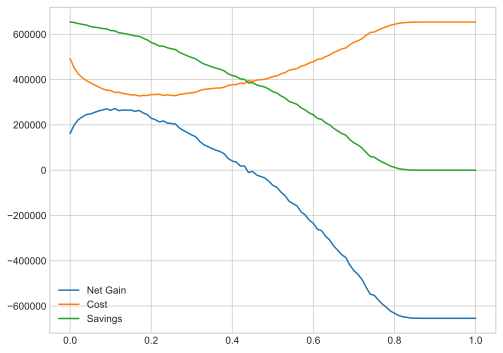

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, logistic_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

**Calculating our total cost and total savings to get net gain:**

In [28]:
conf = confusion_matrix(y_train, pred)

In [33]:
total_cost = (conf[0][1] * 100) + (conf[1][1] * 100)
total_savings = conf[1][1] * 500

In [37]:
net_gain = total_savings - total_cost
print(net_gain)

324900


In [38]:
gs.score(X_train, y_train)

0.8111620795107034

In [39]:
coeffs = gs.best_estimator_.named_steps['clf'].coef_[0]
list_of_coeffs = list(sorted(zip(coeffs*10, X.columns)))

### Gradient Boosting Tuning

In [71]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', GradientBoostingClassifier())])
param_grid = [{'clf__learning_rate': [0.001, 0.1, 1], 'clf__loss': ['deviance', 'exponential'], 'clf__n_estimators': [100, 150], 'clf__max_depth': [3,4,5]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decreas...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__learning_rate': [0.001, 0.1, 1], 'clf__loss': ['deviance', 'exponential'], 'clf__n_estimators': [100, 150], 'clf__max_depth': [3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [100]:
gs.best_params_

{'clf__learning_rate': 0.1,
 'clf__loss': 'exponential',
 'clf__max_depth': 3,
 'clf__n_estimators': 100}

In [101]:
gs.best_score_

0.8074156059767571

In [75]:
np.median(gs.cv_results_['mean_train_score'])

0.8806731722860042

In [ ]:
gs.

In [78]:
gradboost_gain = []
i_vals = []
cost = []
savings = []


for i in np.linspace(0.0, 1.0, 101):
    probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    gradboost_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)
    
print(f'Max net gain = {max(gradboost_gain)}')

Max net gain = 295100


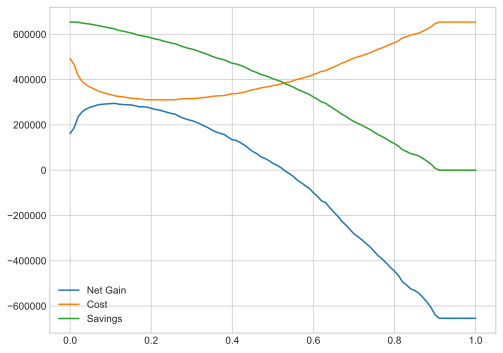

In [79]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, gradboost_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)
plt.save(

### AdaBoost Tuning

In [103]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', AdaBoostClassifier())])
param_grid = [{'clf__learning_rate': [0.01, 0.1, 1], 'clf__algorithm': ['SAMME.R'], 'clf__n_estimators': [50, 100, 150]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__learning_rate': [0.01, 0.1, 1], 'clf__algorithm': ['SAMME.R'], 'clf__n_estimators': [50, 100, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [104]:
gs.best_params_

{'clf__algorithm': 'SAMME.R',
 'clf__learning_rate': 0.1,
 'clf__n_estimators': 50}

In [108]:
np.median(gs.cv_results_['mean_test_score'])

0.7974543442169342

In [109]:
pred = gs.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3614
           1       0.54      0.74      0.62      1308

   micro avg       0.76      0.76      0.76      4922
   macro avg       0.71      0.75      0.72      4922
weighted avg       0.80      0.76      0.77      4922



In [110]:
# Test against our test set
gs.score(X_test, y_test)

0.7468805704099821

In [111]:
np.median(gs.cv_results_['mean_test_score'])

0.7974543442169342

In [112]:
adaboost_gain = []
i_vals = []
cost = []
savings = []


pred = gs.predict(X_train)

for i in np.linspace(0.0, 1.0, 101):
    folds = KFold(n_splits=5,shuffle=True)
    probs = cross_val_predict(gs.best_estimator_,X_train,y_train,cv=folds,method='predict_proba',n_jobs=-1)
    probs = pd.DataFrame(probs)
#     probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    adaboost_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)
    
print(f'Max net gain = {max(adaboost_gain)}')

Max net gain = 266400


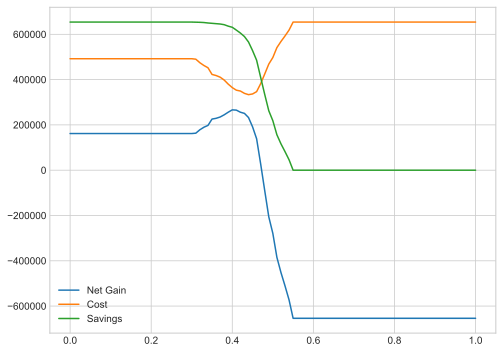

In [113]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, adaboost_gain, label='Net Gain')
plt.plot(i_vals, cost, label='Cost')
plt.plot(i_vals,savings, label='Savings')
plt.legend(loc=0)

### Random Forest Tuning

In [114]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())])
param_grid = [{'clf__max_depth': [4, 5, 6], 'clf__max_features': [5, 10, 15, 20], 'clf__n_estimators': [50, 100, 150]}]
gs = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='recall')
gs.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
     ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__max_depth': [4, 5, 6], 'clf__max_features': [5, 10, 15, 20], 'clf__n_estimators': [50, 100, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [115]:
gs.best_params_

{'clf__max_depth': 5, 'clf__max_features': 5, 'clf__n_estimators': 50}

In [117]:
np.median(gs.cv_results_['mean_test_score'])

0.8218040951853901

In [118]:
pred = gs.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3614
           1       0.59      0.69      0.63      1308

   micro avg       0.79      0.79      0.79      4922
   macro avg       0.73      0.76      0.74      4922
weighted avg       0.80      0.79      0.79      4922



In [119]:
# Test against our test set
gs.score(X_test, y_test)

0.7237076648841355

In [120]:
randforest_gain = []
i_vals = []
cost = []
savings = []


pred = gs.predict(X_train)

for i in np.linspace(0.0, 1.0, 101):
    folds = KFold(n_splits=5,shuffle=True)
    probs = cross_val_predict(gs.best_estimator_,X_train,y_train,cv=folds,method='predict_proba',n_jobs=-1)
    probs = pd.DataFrame(probs)
#     probs = pd.DataFrame(gs.predict_proba(X_train))
    new_pred = probs[1].apply(lambda x: 1 if x > i else 0)
    conf = confusion_matrix(y_train, new_pred)

    total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
    total_savings = conf[1][1] * 500

    net_gain = total_savings - total_cost
    randforest_gain.append(net_gain)
    i_vals.append(i)
    cost.append(total_cost)
    savings.append(total_savings)
    
print(f'Max net gain = {max(randforest_gain)}')

Max net gain = 261400


#### Pickle lists so we don't have to run everything again

In [127]:
# with open('backups/randforest.pkl', 'wb') as f:
#     pickle.dump(randforest_gain, f)
    
# with open('backups/logistic.pkl', 'wb') as f:
#     pickle.dump(logistic_gain, f)
    
# with open('backups/gradboost.pkl', 'wb') as f:
#     pickle.dump(gradboost_gain, f)

#### Compute base case where we predict all customers will churn

In [128]:
y_train.shape

(4922,)

In [129]:
new_pred = np.ones(shape=(4922,))

conf = confusion_matrix(y_train, new_pred)

total_cost = (conf[0][1] * 100) + (conf[1][1] * 100) + conf[1][0] * 500
total_savings = conf[1][1] * 500

net_gain = total_savings - total_cost

In [131]:
conf

array([[   0, 3614],
       [   0, 1308]])

In [132]:
net_gain

161800

#### Compute base case where we do nothing

In [137]:
# 1308 customers will churn, at an average cost to replace of $500 each
# $654,000 loss, which is why our predictions bottom out at that number on the following chart (good to confirm that it does!)
1308 * 500

654000

### Plot all Net Gain scores against each other

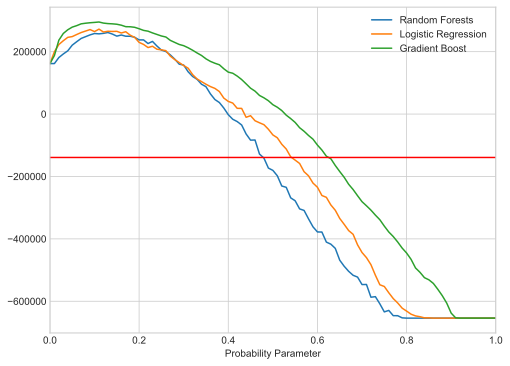

In [139]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(i_vals, randforest_gain, label='Random Forests')
plt.plot(i_vals, logistic_gain, label='Logistic Regression')
plt.plot(i_vals, gradboost_gain, label='Gradient Boost')
ax.axhline(y=-139130, color='r')
plt.legend(loc=0)
ax.set_xlabel('Probability Parameter')
ax.set_xbound(lower=0, upper=1.0)
# plt.savefig('visualizations/net_cost_2.svg')

##  Cost minimization: 

In [42]:
def makecost(obs,prob,falsepos_cost,falseneg_cost):
    def cost(cutoff):
        pred = np.array(prob > cutoff)
        fpos = pred * (1 - obs) 
        fneg = (1 - pred) * obs
        return np.sum(fpos * falsepos_cost + fneg * falseneg_cost)
    return np.vectorize(cost)

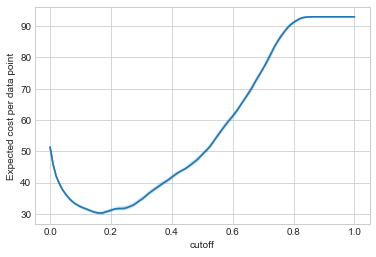

In [45]:
cut = np.linspace(0,1,100)
cost = np.zeros_like(cut)
from sklearn.model_selection import KFold, cross_val_predict
obs = y_train

K = 20
for j in range(K):
    folds = KFold(n_splits=5,shuffle=True)
    prob = cross_val_predict(gs.best_estimator_,X_train,obs,cv=folds,method='predict_proba',n_jobs=5)[:,1]
    getcost = makecost(obs,prob,falsepos_cost=100,falseneg_cost=500)
    currentcost = getcost(cut)/X.shape[0]
    cost += currentcost
    plt.plot(cut, currentcost,c='C0',alpha=0.05)
cost /= K
plt.plot(cut,cost,c='C0')
plt.xlabel('cutoff')
plt.ylabel('Expected cost per data point');

In [44]:
bestcut = cut[np.argmin(cost)]
bestcut

0.16161616161616163